<a href="https://colab.research.google.com/github/limonheiro/Pix2PixGenerator/blob/main/preto_e_branco_para_colorido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando Bibliotecas

In [1]:
from __future__ import print_function, division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import numpy as np

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# from google.colab import drive
# drive.mount('/content/drive')

#Descompactando o Dataset

In [2]:
!unzip -q "landscape Images.zip"

In [3]:
!ls landscape\ Images/color | tail

992.jpg
993.jpg
994.jpg
995.jpg
996.jpg
997.jpg
998.jpg
999.jpg
99.jpg
9.jpg


In [4]:
!ls landscape\ Images/gray | tail

992.jpg
993.jpg
994.jpg
995.jpg
996.jpg
997.jpg
998.jpg
999.jpg
99.jpg
9.jpg


In [5]:
default_patch = "landscape Images/"

##Variaveis do sistema

In [6]:
color = 'color/'
gray = 'gray/'
dataset = default_patch
LAMBDA = 100.0
BATCH_SIZE = 1
gf=64
df=64


IMG_HEIGHT=256//2
IMG_WIDTH=256//2
CHANNELS = 3

img_shape = (IMG_HEIGHT,
                  IMG_WIDTH,
                  CHANNELS)

In [7]:
def load( image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image, channels=3)

  # Convert both images to float32 tensors
  input_image = tf.cast(image, tf.float32)
  return input_image

# Normalizing the images to [-1, 1]
def normalize( input_image):
  input_image = (input_image / 127.5) - 1
  return input_image

def resize( input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

def load_image_train( image_file):
  input_image = load(image_file)
  input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
  input_image = normalize(input_image)

  return input_image

In [8]:
#load dataset
color_dataset = tf.data.Dataset.list_files(str(dataset + color + '*.jpg'), shuffle=False)
color_dataset = color_dataset.map(load_image_train,num_parallel_calls=1)

gray_dataset = tf.data.Dataset.list_files(str(dataset + gray + '*.jpg'), shuffle=False)
gray_dataset = gray_dataset.map(load_image_train,num_parallel_calls=1)

size_t = len(color_dataset)
train_size = int(size_t * 0.9)
test_size = int(size_t * 0.1)

dataset_data = tf.data.Dataset.zip((gray_dataset, color_dataset))
# dataset_data = dataset_data.shuffle(size_t)
train_dataset = dataset_data.take(train_size)
test_dataset = dataset_data.skip(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
im=next(iter(color_dataset.take(1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


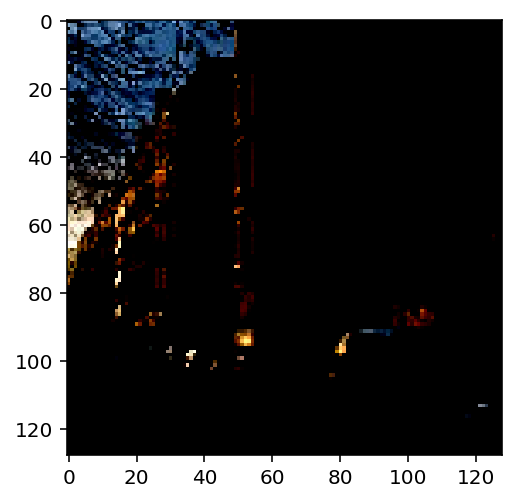

In [10]:
plt.imshow(im)

In [11]:
im=next(iter(gray_dataset.take(1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


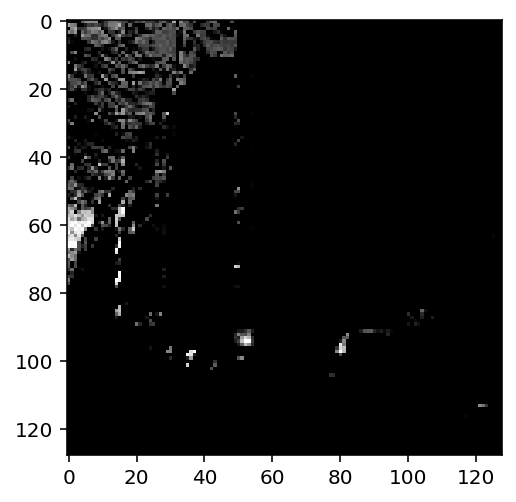

In [12]:
plt.imshow(im)

In [13]:
example_input, example_target = next(iter(train_dataset.take(10)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


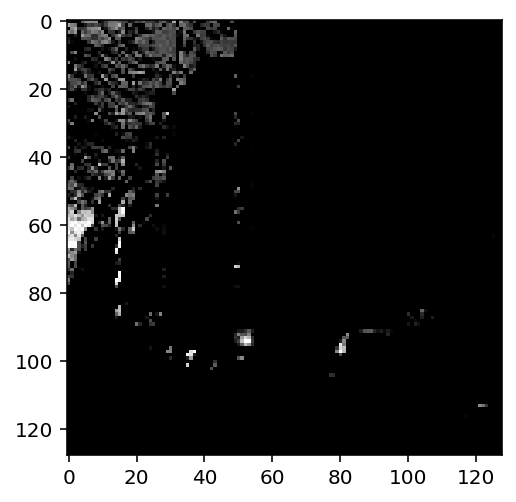

In [14]:
plt.imshow(example_input[0][:,:,::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


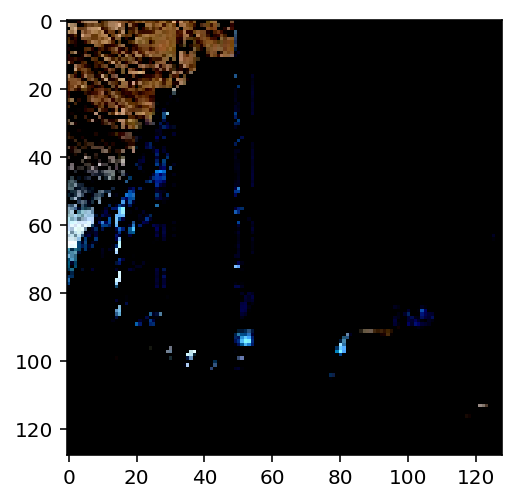

In [15]:
plt.imshow(example_target[0][:,:,::-1])

In [16]:
# define an encoder block
def conv2d(layer_in, n_filters, f_size=4, batchnorm=True, strides=2):
  initializer = tf.random_normal_initializer(0., 0.02)
  # add downsampling layer
  g = Conv2D(n_filters, 
              kernel_size=f_size, 
              strides=strides, 
              padding='same',
             kernel_initializer=initializer,
             use_bias=False)(layer_in)

  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization(momentum=0.8)(g, training=False)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g 

  # define an dencoder block
def deconv2d(layer_in, skip_in, n_filters, f_size=4, dropout=False):

  initializer = tf.random_normal_initializer(0., 0.02)

  g = Conv2DTranspose(n_filters, 
            kernel_size=f_size, 
            strides=2, 
            padding='same', 
            activation='relu',
            kernel_initializer=initializer,
            use_bias=False)(layer_in)

  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g)
  # add batch normalization
  g = BatchNormalization(momentum=0.8)(g)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  return g

In [17]:
def build_generator():
  #U-net Generator
  initializer = tf.random_normal_initializer(0., 0.02)
  # define an E-Net block
  # image input
  in_image = Input(shape=img_shape)

  # encoder model
  e1 = conv2d(in_image, gf,batchnorm=False)
  # e0 = conv2d(in_image, n_filters=gf,f_size=3,batchnorm=False)
  e2 = conv2d(e1, gf*2)
  e3 = conv2d(e2, gf*4)
  e4 = conv2d(e3, gf*8)
  e5 = conv2d(e4, gf*8)

  lt = Conv2D(filters=512, kernel_size=(4,4), strides=(2,2), padding='same')(e5)
  ac= Activation('relu')(lt)

  # decoder model
  #deconv2d(layer_in,skip_in,n_filters,f_size=4,dropout=False)
  d1 = deconv2d(ac, e5, gf*8, dropout=True)
  d2 = deconv2d(d1, e4, gf*8, dropout=True)
  d3 = deconv2d(d2, e3, gf*4)
  d4 = deconv2d(d3, e2, gf*2)
  d5 = deconv2d(d4, e1, gf)

  output_img = Conv2DTranspose(filters=3, 
                      kernel_size=4,
                      strides=(2,2),
                      padding='same',
                  activation='tanh')(d5)

  return Model(inputs=in_image, outputs=output_img)

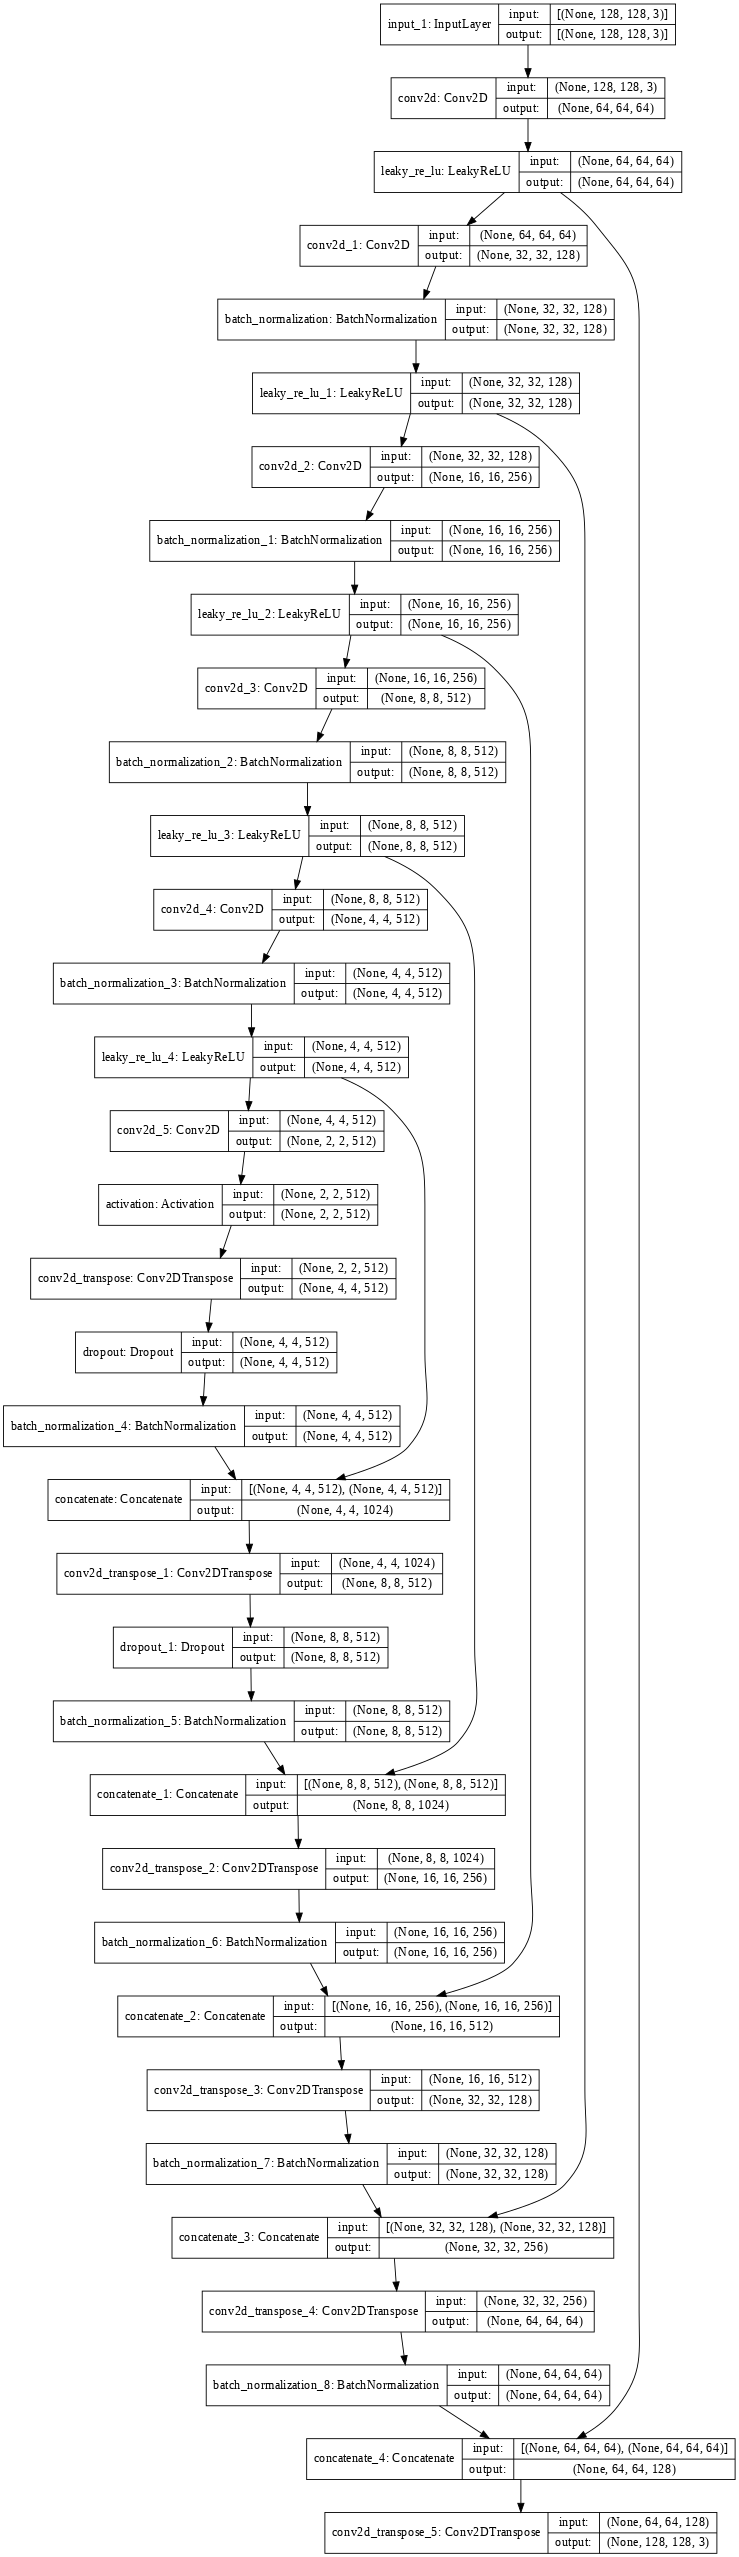

In [18]:
generator = build_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [19]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131072      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [20]:
!ls drive/MyDrive/landscape\ Images/color/1738.jpg

ls: cannot access 'drive/MyDrive/landscape Images/color/1738.jpg': No such file or directory


In [21]:
image = tf.io.read_file('landscape Images/color/1738.jpg')
inp = tf.image.decode_image(image)
inp = tf.image.resize(inp, [128,128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


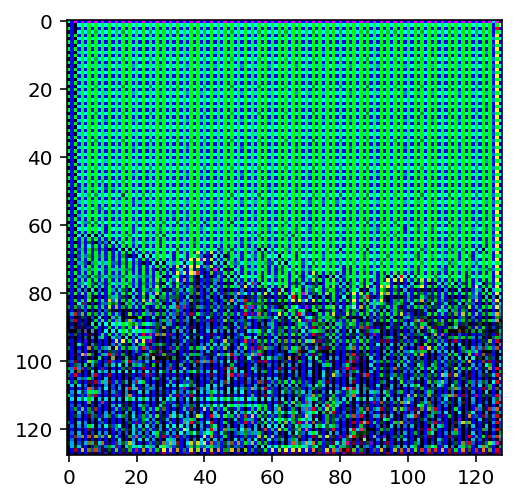

In [22]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [23]:
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=Q1Xbz5OaLj5C
LAMBDA = 100.0
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
@tf.function
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = tf.add(gan_loss , tf.multiply(LAMBDA, l1_loss))

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def build_discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  img_A = Input(shape=img_shape, name='input_image')
  img_B = Input(shape=img_shape, name='target_image')

  # Concatenate image and conditioning image by channels to produce input
  combined_imgs = Concatenate(axis=-1)([img_A, img_B])

  d1 = conv2d(combined_imgs, df, batchnorm=False)
  d2 = conv2d(d1, df*2)
  d3 = conv2d(d2, df*4)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(d3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)


  b = BatchNormalization()(conv)
  le = LeakyReLU(alpha=0.2)(b)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(le)

  validity = Conv2D(1, kernel_size=4, strides=1)(zero_pad2)

  return Model(inputs=[img_A, img_B], outputs=validity)

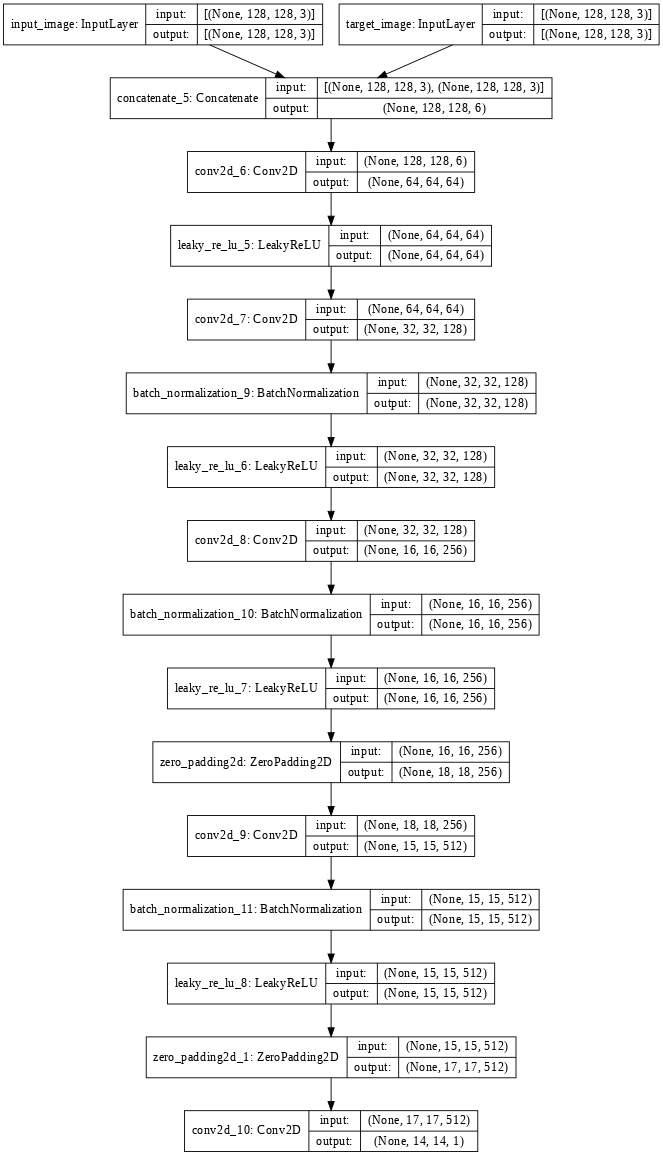

In [25]:
discriminator = build_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

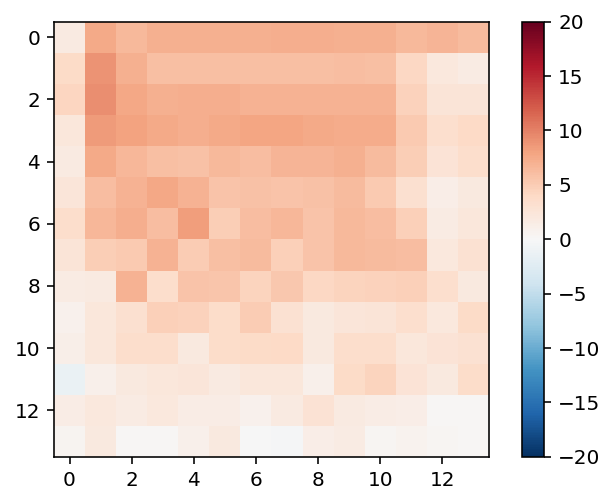

In [26]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

##CheckPoints

In [28]:
generator_optimizer = Adam(2e-4, beta_1=0.9)
discriminator_optimizer = Adam(2e-4, beta_1=0.9)

In [29]:
try:
  os.mkdir(default_patch+'check')
except FileExistsError:
    pass


In [30]:
checkpoint_dir = default_patch+'check'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

##Test Imagens

In [31]:
def sample_images(model, epoch, epochs, Input, Target):
  prediction = model(Input, training=True)
  os.makedirs('images/%s' % 'gaze_eye_face', exist_ok=True)
  plt.figure(figsize=(15, 15))

  r, c = 1, 3

  inputI = Input[0] 
  target = Target[0] 
  pred = prediction[0] 
  
  gen_imgs = [Input[0] , Target[0], prediction[0]]
  titles = ['Input', 'Target', 'Generated']
  for j in range(c):
    plt.subplot(1, c, j+1)
    plt.title(titles[j])
    plt.axis('off')
    plt.imshow(gen_imgs[j][:,:,::-1] * 0.5 + 0.5)
    plt.savefig(default_patch+"/%d_%d.png" % (int(epoch+1), int(epochs)))
  plt.show()

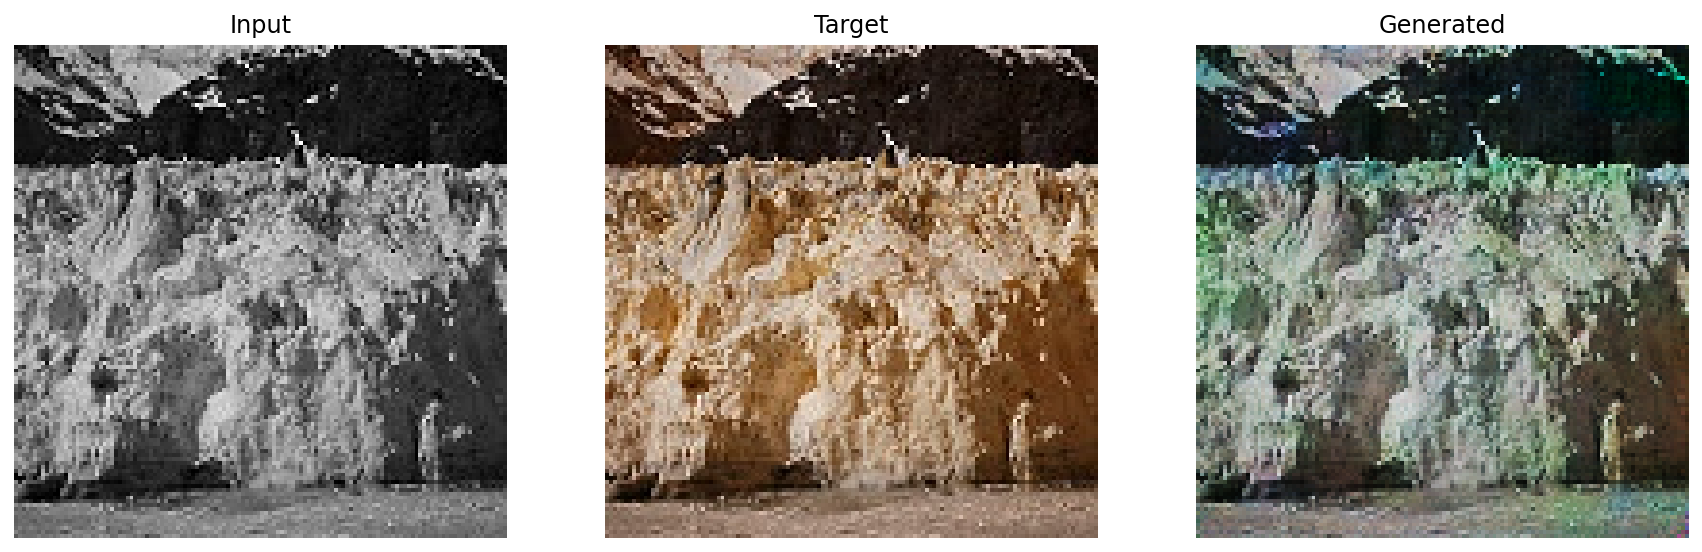

In [39]:
for example_input, example_target in test_dataset.take(1):
  sample_images(model=generator, epoch=-1, epochs=200,Input=example_input, Target=example_target)

In [33]:
log_dir=default_patch+"logs/"
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/')

In [34]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [35]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(10)))
  start_time = datetime.datetime.now() 
  start = datetime.datetime.now()
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      elapsed_time = datetime.datetime.now() - start_time

      if step != 0:
        print(f'Time taken for 1000 steps: {datetime.datetime.now() - start} sec\n')
        
      start = datetime.datetime.now()

      sample_images(model=generator,epoch=step, epochs=steps, Input=example_input, Target=example_target)
      print(f"Step: {(step)//1000}k")
      print(f'elapsed_time Time: {elapsed_time}')

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print(f'.', end='', flush=True)


    # Save (checkpoint) the model every 10k steps
    if (step + 1) % 25_000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [36]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

Time taken for 1000 steps: 0:00:29.850305 sec



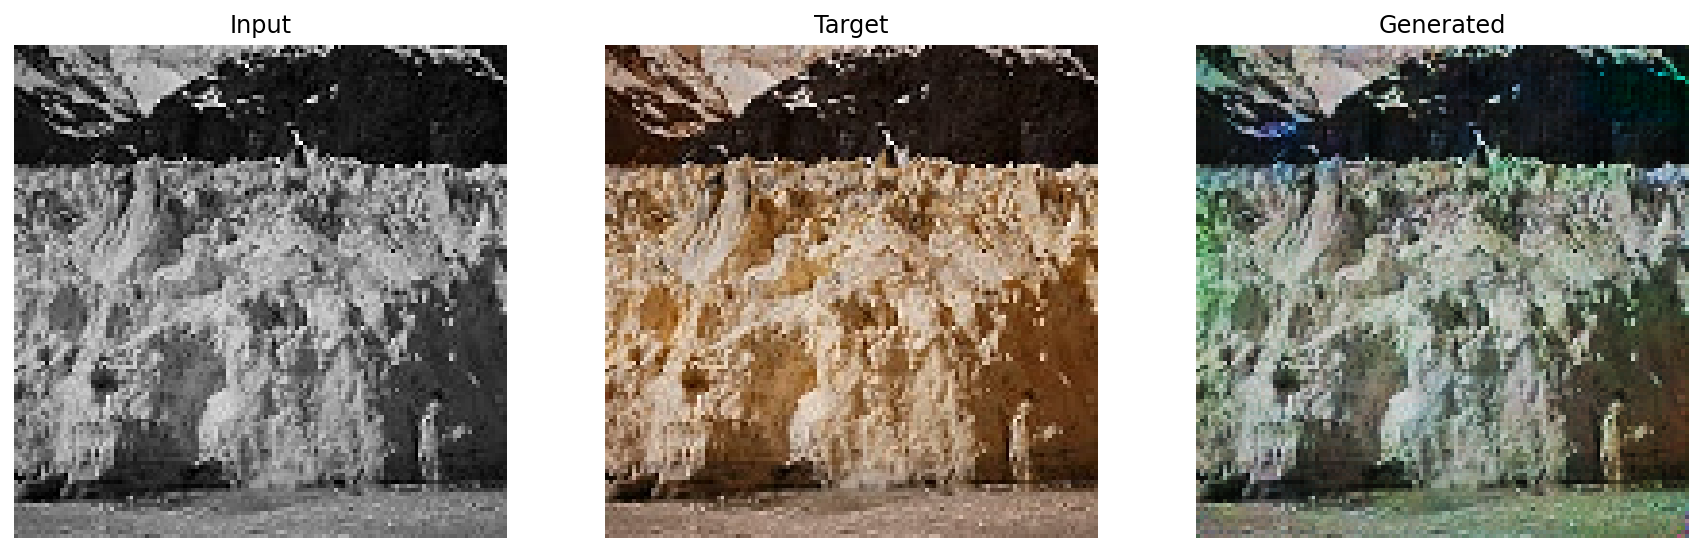

Step: 1999k
elapsed_time Time: 16:34:47.868535
....................................................................................................

In [37]:
fit(train_dataset, test_dataset, steps=2_000_000)

In [38]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")